In [23]:
#importing all necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

from sklearn.preprocessing import LabelEncoder
from itertools import chain # for flatting the list
#from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


from transformers import BertModel
from transformers import BertTokenizer
from transformers import AutoModel, AutoTokenizer

###
###from indic_transliteration import sanscript
###from indic_transliteration.sanscript import SchemeMap, SCHEMES, transliterate

import re
import unicodedata
import codecs
import random

In [24]:
# for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [25]:
random.random()

0.6754235223743336

In [26]:
#dataset classs for ATIS data
class ATIS(Dataset):

  def __init__(self, file_name, translit_prob=0, shuffle_prob=0, max_token_len=100):
    super(ATIS, self).__init__()

    self.df = pd.read_csv(file_name, header=None)
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    self.max_token_len = max_token_len
    self.translit_prob = translit_prob
    self.shuffle_prob = shuffle_prob

    self.label_encoder = LabelEncoder().fit(list(self.df[0]))


  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    query = self.df.iloc[index, 1]
    query = self.query_preprocessing(query)

    if random.random() < self.shuffle_prob:
      query_list = query.split()
      if len(query_list) < 10:
        random.shuffle(query_list)
        query = " ".join(query_list)



    label = self.label_encoder.transform([self.df.iloc[index, 0]])

    # print(query)
    # print(label)

    tokens = self.tokenizer.tokenize(query)
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    if len(tokens) < self.max_token_len:
      tokens = tokens + ['[PAD]' for i in range(self.max_token_len-len(tokens))]
    else:
      tokens = tokens[:self.max_token_len-1] + ['[SEP]']

    token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

    token_id_tensor = torch.tensor(token_ids)
    label_tensor = torch.tensor(label)
    attention_mask_tensor = (token_id_tensor != 0).long()

    return token_id_tensor, attention_mask_tensor, label_tensor

  def unicodeToAscii(self, s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

  def normalizeString(self, s):
    s = self.unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s


  def query_preprocessing(self, query_text):
    q= self.normalizeString(query_text)

    if random.random() < self.translit_prob:                      ## translit according to translit probability
      q = transliterate(q, sanscript.HK, sanscript.MALAYALAM)
    return q

In [29]:

final_test_file = '/kaggle/input/tanglishbertmodel/tamil_test.csv'

In [30]:
# creating instance of datset class

final_test_set = ATIS(file_name = final_test_file, max_token_len=120, translit_prob=0, shuffle_prob=0)

In [31]:

print(final_test_set)

In [33]:
final_test_set[6]

(tensor([   101,  83279,  10111,  34481,  17776,  10138,  86168,  10679,  86168,
          10679,  86168,  10679,  23152,  10371, 108270,  10330,  22038,  22205,
          10107,    102,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,    

In [34]:

test_loader = DataLoader(final_test_set, batch_size = 64, num_workers =4, shuffle=False)

In [36]:
for i, data in enumerate(test_loader, 0):
  print(data[0].shape)
  print(data[1].shape)
  print(data[2].shape)
  break

torch.Size([64, 120])
torch.Size([64, 120])
torch.Size([64, 1])


In [37]:
class INTENT_CLASSIFIER(nn.Module):

  def __init__(self, freeze_bert=True):
    super(INTENT_CLASSIFIER, self).__init__()

    self.bert_layers = BertModel.from_pretrained('bert-base-multilingual-uncased',return_dict=False)
    self.linear1 = nn.Linear(768, 300)
    self.linear11 = nn.Linear(300, 8)
    self.linear2 = nn.Linear(8, 2)
    self.dropout = nn.Dropout(0.5)

    if freeze_bert:
      for param in self.bert_layers.parameters():
        param.requires_grad = False


  def forward(self, token_ids, atten_mask):
    """Both argument are of shape: batch_size, max_seq_len"""
    _, CLS = self.bert_layers(token_ids, attention_mask = atten_mask)
    logits = self.dropout(self.linear1(CLS))
    logits = self.dropout(self.linear11(logits))
    logits = self.linear2(logits)

    return logits

In [41]:
model = torch.load('/kaggle/input/tanglishbertmodel/best_model.pth')

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [43]:
model.to(device)
print(f"model loaded to {device}")

model loaded to cuda


In [46]:
# Getting the test accuracy
def test():
  correct = 0
  total = 0
  model.eval()
  y_test_prediction = []
  y_test_true = []

  with torch.no_grad():
      for data in test_loader:
          tokens, masks, labels = data

          tokens = tokens.to(device)
          masks = masks.to(device)
          labels = labels.to(device)

          outputs = model(tokens, masks)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels.squeeze()).sum().item()

          y_test_true += labels.squeeze().detach().cpu().numpy().tolist()
          y_test_prediction += predicted.detach().cpu().numpy().tolist()

  print('Test Accuracy: {}%'.format(100 * correct / total))
  test_accuracy_value = correct/total
  return y_test_true, y_test_prediction, test_accuracy_value

In [47]:
y_test_true, y_test_prediction, _ = test()
#y_train_true, y_train_prediction= train_acc()

Test Accuracy: 82.63305322128852%


In [49]:
final_test_set.label_encoder.inverse_transform([0, 1])

array(['Negative', 'Positive'], dtype='<U8')

In [50]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report

In [51]:
target_names = ['Negative ', 'Positive']

In [52]:
print("Test Accuracy", accuracy_score(y_test_true, y_test_prediction))
#print("Train Accuracy", accuracy_score(y_train_true, y_train_prediction))
print("Test Kappa Score", cohen_kappa_score(y_test_true, y_test_prediction))
#print("Train Kappa Score", cohen_kappa_score(y_train_true, y_train_prediction))

Test Accuracy 0.8263305322128851
Test Kappa Score 0.15321866631272396


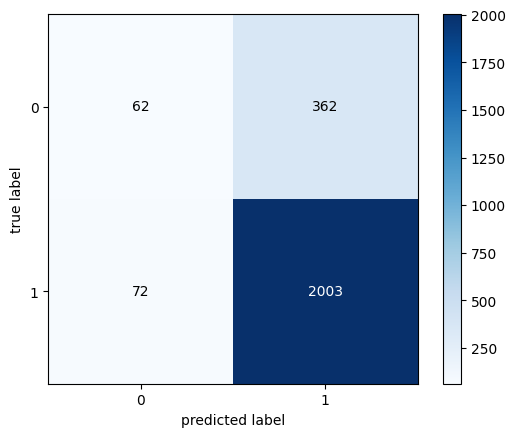

In [53]:
multiclass = confusion_matrix(y_test_true, y_test_prediction)

class_names = target_names

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False)
plt.show()

In [54]:
#without transliteration data augmentation
print(classification_report(y_test_true, y_test_prediction))

              precision    recall  f1-score   support

           0       0.46      0.15      0.22       424
           1       0.85      0.97      0.90      2075

    accuracy                           0.83      2499
   macro avg       0.65      0.56      0.56      2499
weighted avg       0.78      0.83      0.79      2499

